In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

## Gradient descent algorithm

In [ ]:
def gradient_descent(A, b, x0, gamma, epsilon=1e-8, max_iter=100000):
    """
    Gradient descent algorithm for solving the problem of minimizing the quadratic function
    where f(x) = 0.5 * (x^T A x) + b^T x
    """
    k = 0
    xk = x0
    path = [xk.copy()]  # Store the path of iterations
    d = -(A @ xk + b)
    while k < max_iter and np.linalg.norm(d) > epsilon:
        t = ((d.T @ d) / (d.T @ A @ d))
        if gamma == -1:
            t = t * np.random.uniform(0, 1)
        else:
            t = t * gamma
        xk = xk + t * d
        path.append(xk.copy())  # Append the current xk to the path
        d = -(A @ xk + b)
        k = k + 1
    return xk, k, np.array(path)

def plot_path(A, b, x0, gamma = 1.0):
    # Run gradient descent
    start_time = time()
    x_sol, num_iterations, path = gradient_descent(A, b, x0, gamma)
    end_time = time()
    
    x_max = np.max(np.abs(path[:, 0])) + 1
    y_max = np.max(np.abs(path[:, 1])) + 1
    
    x_vals = np.linspace(-x_max, x_max, 100)
    y_vals = np.linspace(-y_max, y_max, 100)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = 0.5 * (A[0, 0]*X**2 + 2*A[0, 1]*X*Y + A[1, 1]*Y**2) + b[0]*X + b[1]*Y
    
    plt.figure(figsize=(6, 3))
    plt.contour(X, Y, Z, levels=50, cmap='viridis')
    plt.plot(x0[0], x0[1], 'ro', label='Initial Point')
    plt.plot(x_sol[0], x_sol[1], 'go', label='Solution')
    
    plt.plot(path[:, 0], path[:, 1], 'r--', label='Path of Gradient Descent')
    plt.title(f'Gradient Descent Convergence (Iterations: {num_iterations}, Time: {end_time - start_time:.4f}s)')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.show()

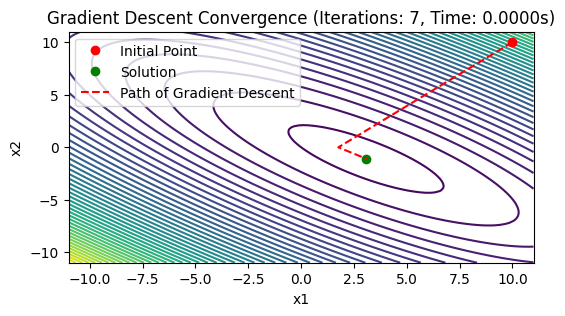

In [3]:
# Define a simple quadratic function and its parameters
def quadratic_function(x):
    return 0.5 * x.T @ A @ x + b.T @ x

# Parameters for the quadratic function
A = np.random.rand(2, 2) * 2
A = A.T @ A
b = np.array([-6, -4])
x0 = np.array([10, 10])  # Initial guess

plot_path(A, b, x0, gamma = 1.0)

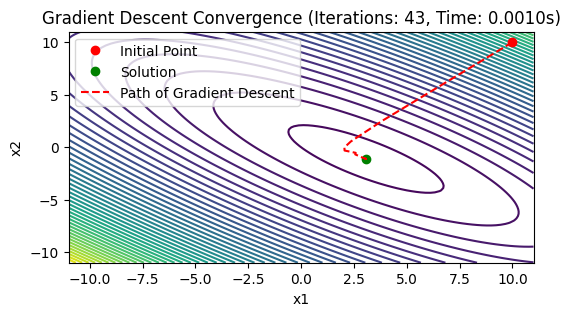

In [4]:
plot_path(A, b, x0, gamma = 0.75)

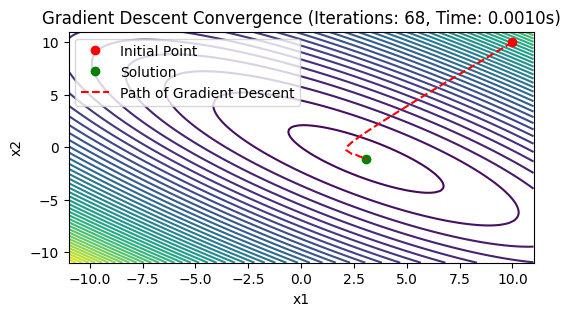

In [5]:
plot_path(A, b, x0, gamma = 0.5)

## Barzilai-Borwein-Raydan (BBR) method

In [6]:
def i_partial_derivative(f, x, i, h=0.1, epsilon=1e-6):
    e_i = np.zeros(len(x))
    e_i[i] = 1
    z = (f(x + h*e_i) - f(x - h*e_i)) / (2 * h)
    h = h / 2
    y = (f(x + h*e_i) - f(x - h*e_i)) / (2 * h)  # to compare with z
    while np.linalg.norm(y - z) > epsilon and (y != np.nan) and (y != np.inf):
        z = y
        h = h / 2
        y = (f(x + h*e_i) - f(x - h*e_i)) / (2 * h)
    return z

def gradient(f, x):
    res = np.zeros(len(x))
    for i in range(len(x)):
        res[i] = i_partial_derivative(f, x, i)
    return res

# Wolfe Search Algorithm
def wolfe(f, x, d, c1=0.5, c2=0.75):
    alpha = 0
    t = 1
    beta = np.inf
    for j in range(1000):
        g = gradient(f, x)
        if f(x + t * d) > f(x) + c1 * t * g.T @ d:
            beta = t
            t = (alpha + beta) / 2
        elif gradient(f, x + t * d).T @ d < c2 * g.T @ d:
            alpha = t
            if beta == np.inf:
                t = 2 * alpha
            else:
                t = 0.5 * (alpha + beta)
        else:
            break
    return t

# Barzilai-Borwein-Raydan (BBR) Method for any function
def generic_BBR_method(f, x0, epsilon=1e-6, kmax=10000):
    xk_prev = x0
    dk = -gradient(f, xk_prev)
    tk = wolfe(f, xk_prev, dk)
    xk = xk_prev + tk * dk
    path = [x0, xk]
    k = 1
    while np.linalg.norm(gradient(f, xk)) > epsilon and k < kmax:
        dk = -gradient(f, xk)
        yk_prev = gradient(f, xk) - gradient(f, xk_prev)
        sk_prev = xk - xk_prev
        tk = (sk_prev.T @ sk_prev) / (sk_prev.T @ yk_prev)
        xk_prev = xk
        xk = xk + tk * dk
        k = k + 1
        path.append(xk)
    return xk, k, np.array(path)

The formula for the function `exponencial_diff(x)` is:

$$
f(x) = 2 \left( e^{-x_0^2 - x_1^2} - e^{-(x_0 - 1)^2 - (x_1 - 1)^2} \right)
$$

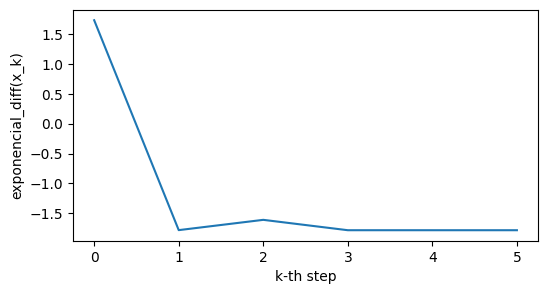

In [7]:
def exponencial_diff(x):
    s1 = np.exp(-x[0] ** 2 - x[1] ** 2)
    s2 = np.exp(-(x[0] - 1) ** 2 - (x[1] - 1) ** 2)
    return (s1 - s2) * 2

xsol, k, recorrido = generic_BBR_method(exponencial_diff, [0, 0])
ks = np.arange(k)
ys = np.zeros(k)
for i in range(k):
    ys[i] = exponencial_diff(recorrido[i])

plt.figure(figsize=(6,3))
plt.plot(ks, ys)
plt.xlabel('k-th step')
plt.ylabel('exponencial_diff(x_k)')
plt.show()

## Cuasi Newton method

In [8]:
def plot_fun(f, limites, points=None):
    x = np.linspace(limites[0], limites[1], 100)
    y = np.linspace(limites[2], limites[3], 100)
    X, Y = np.meshgrid(x, y)
    Z = f([X, Y])

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)

    if points is not None:
        for p in points:
            ax.scatter(p[0], p[1], p[2], color='r', s=50)

    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    plt.show()

In [9]:
# Bird Function and its global minimum
def bird(x):
    t1 = (x[0] - x[1])**2
    t2 = np.sin(x[0])*np.exp((1-np.cos(x[1]))**2)
    t3 = np.cos(x[1])*np.exp((1-np.sin(x[0]))**2)
    return  t1 + t2 + t3

x_min1 = np.array([4.701055751981055,3.152946019601391])
x_min2 = np.array([-1.582142172055011,-3.130246799635430])

In [10]:
# Golden-section search
def golden_section(f, x, d, epsilon=1e-6, phro = 1):
    theta1 = (3-np.sqrt(5))/2
    theta2 = 1 - theta1
    a = 0
    s = phro
    b = 2*phro
    phib = f(x + b*d)
    phis = f(x + s*d)
    while phib < phis:
        a = s
        s = b
        b = 2*b
        phis = phib
        phib = f(x + b*d)
    u = a + theta1 * (b - a)
    v = a + theta2 * (b - a)
    phiu = f(x + u*d)
    phiv = f(x + v*d)
    while b - a > epsilon:
        if phiu < phiv:
            b = v
            v = u
            u = a + theta1 * (b - a)
            phiv = phiu
            phiu = f(x + u*d)
        else:
            a = u
            u = v
            v = a + theta2 * (b - a)
            phiu = phiv
            phiv = f(x + u*d)
    return (u + v) / 2

In [11]:
# Cuasi Newton method
def cuasi_newton_generic(f, xk, Hk, epsilon=1e-10, kmax=1000, metodo='Broyden'):
    k = 0
    while np.linalg.norm(gradient(f, xk)) > epsilon and k < kmax:
        dk = - Hk @ gradient(f, xk)
        #tk = wolfe(f, xk, dk, epsilon=epsilon)
        #tk = armijo(f, xk, dk, epsilon=epsilon)
        tk = golden_section(f, xk, dk, epsilon=epsilon)

        # Get Hk+1 >~ 0
        xkm1 = xk + tk * dk
        yk = gradient(f, xkm1) - gradient(f, xk)
        sk = xkm1 - xk
        if metodo == 'Broyden':

            #Hkm1 = Hk + np.outer(sk - Hk @ yk, sk - Hk @ yk) / (yk.T @ (sk - Hk @ yk))

            sk_Hk_yk = sk - Hk @ yk
            # Sherman-Morrison formula
            Hk += np.outer(sk_Hk_yk, sk_Hk_yk) / (yk.T @ sk_Hk_yk)

        # DFP y BFGS
        elif metodo == 'DFP':
            Hk += np.outer(sk, sk) / (yk.T @ sk) - (Hk @ np.outer(yk, yk) @ Hk) / (yk.T @ Hk @ yk)
        elif metodo == 'BFGS':
            skT_yk = sk.T @ yk
            Hk += (1 + (yk.T @ Hk @ yk) / (skT_yk)) * np.outer(sk, sk) / (skT_yk) - (np.outer(sk, yk) @ Hk + Hk @ np.outer(yk, sk)) / (skT_yk)
        else:
            Hk = np.eye(len(xk)) 

        xk = xkm1
        k = k+1
    return xk, k

### 5.1

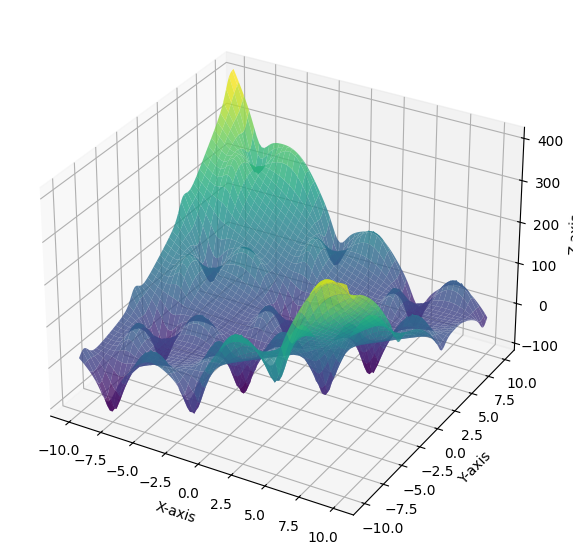

In [12]:
c = 10
plot_fun(bird, (-c, c, -c, c))

### 5.2

C:\Users\aaron\AppData\Local\Temp\ipykernel_6384\1385125908.py:27: RuntimeWarning: invalid value encountered in scalar divide
  Hk += (1 + (yk.T @ Hk @ yk) / (skT_yk)) * np.outer(sk, sk) / (skT_yk) - (np.outer(sk, yk) @ Hk + Hk @ np.outer(yk, sk)) / (skT_yk)
C:\Users\aaron\AppData\Local\Temp\ipykernel_6384\1385125908.py:27: RuntimeWarning: invalid value encountered in divide
  Hk += (1 + (yk.T @ Hk @ yk) / (skT_yk)) * np.outer(sk, sk) / (skT_yk) - (np.outer(sk, yk) @ Hk + Hk @ np.outer(yk, sk)) / (skT_yk)


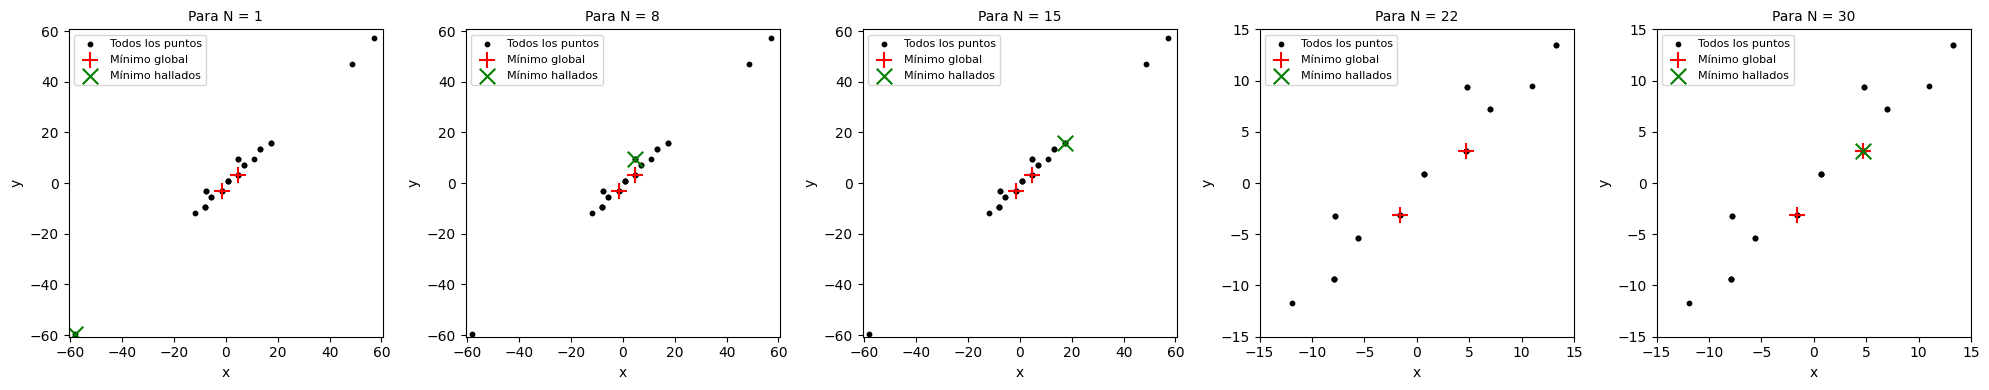

In [13]:
def random_restart(f, N, c):
    soluciones = []
    mejor = np.array([10, 10]) 
    np.random.seed(69)

    for i in range(N):
        x0 = np.random.uniform(-c, c, 2)
        xsol, _ = cuasi_newton_generic(f, x0, np.eye(2), epsilon=1e-10, metodo='BFGS')
        soluciones.append(xsol)
        if f(xsol) < f(mejor):
            mejor = xsol
    return np.array(soluciones), mejor

def plot_solutions(xsol, N, c, x_min1, x_min2):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    for idx, i in enumerate(np.linspace(1, N, 5, dtype=int)):
        res = xsol[:i]
        ax = axs[idx]
        ax.scatter(xsol[:, 0], xsol[:, 1], s=10, c='k', label='Todos los puntos')
        ax.scatter(x_min1[0], x_min1[1], marker='+', s=125, c='r', label='Mínimo global')
        ax.scatter(x_min2[0], x_min2[1], marker='+', s=125, c='r')

        ax.scatter(res[(i-1):, 0], res[(i-1):, 1], marker='x', c='g', s=125, label='Mínimo hallados')
        l = max(c, np.max(np.abs(res)) + 1)
        ax.set_xlim(-l, l)
        ax.set_ylim(-l, l)
        ax.set_title(f'Para N = {i}', fontsize=10)
        ax.set_xlabel('x', fontsize=10)
        ax.set_ylabel('y', fontsize=10)
        ax.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

xsols, mejor = random_restart(bird, N=30, c=15)
plot_solutions(xsols, N=30, c=15, x_min1=x_min1, x_min2=x_min2)

## Stochastic Search